<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/1_3_MNIST_deep_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import SGD

In [2]:
# 정확도 측정 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

# Plot 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.title("Train vs Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

[MYCODE] dataset 리팩토링

- dataset 중복코드 제거
- trainset 생성
- testset 생성

In [3]:
transform = transforms.ToTensor()

def get_dataset(train= True, download=True):
    return torchvision.datasets.CIFAR10(
    root='./data',
    train=train,
    download=download,
    transform=transform
)

batch_size = 256
def get_loader(dataset, suffle=True):
    return torch.utils.data.DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=suffle
)


trainset = get_dataset()
testset = get_dataset(False)

trainloader = get_loader(trainset)
testloader = get_loader(testset, False)


100%|██████████| 170M/170M [00:02<00:00, 71.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
batch_size, channels, height, width = images.shape

# 이미지 크기와 채널 수 확인
print(f"Image shape: {images.shape}")  # 출력 예: (256, 3, 32, 32)
print(f"Batch size: {batch_size}")
print(f"Number of channels: {channels}")
print(f"Height: {height}")
print(f"Width: {width}")

Image shape: torch.Size([256, 3, 32, 32])
Batch size: 256
Number of channels: 3
Height: 32
Width: 32


[MYCODE] LeakyReLU 변경

- 손실함수를 ReLU 에서 LeakyReLU 변경한다.

In [5]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # 활성함수를 삭제
    return self.layer3(x)


model = Model(width * height * channels, 1024).to('cuda')

In [6]:
lr = 0.001
model = model.to('cuda')
optimizer = SGD(model.parameters(), lr=lr)

In [7]:
cretaition = nn.CrossEntropyLoss()

[LOG] 학습과정에서 에포크별 손실값, Train, Test 표시

In [8]:
n_epochs = 50

# Lists for Accuracy Tracking
train_accs = []
test_accs = []


for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    #print(f"모델 출력 크기: {preds.shape}")
    #print(f"모델 출력 값(샘플): {preds[0]}")

    assert labels.min() >= 0, "음수 값이 포함되어 있습니다!"
    assert labels.max() < 10, "클래스 개수를 초과합니다!"
    assert labels.dtype == torch.int64, "라벨 타입이 torch.LongTensor가 아닙니다!"

    loss = cretaition(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # Epoch 종료 후 정확도 계산
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss / len(trainloader):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")



Epoch 1/50, Loss: 2.2980, Train Acc: 0.1237, Test Acc: 0.1244
Epoch 2/50, Loss: 2.2880, Train Acc: 0.1216, Test Acc: 0.1216
Epoch 3/50, Loss: 2.2790, Train Acc: 0.1330, Test Acc: 0.1339
Epoch 4/50, Loss: 2.2703, Train Acc: 0.1498, Test Acc: 0.1493
Epoch 5/50, Loss: 2.2612, Train Acc: 0.1672, Test Acc: 0.1658
Epoch 6/50, Loss: 2.2515, Train Acc: 0.1781, Test Acc: 0.1790
Epoch 7/50, Loss: 2.2410, Train Acc: 0.1952, Test Acc: 0.1942
Epoch 8/50, Loss: 2.2297, Train Acc: 0.2150, Test Acc: 0.2130
Epoch 9/50, Loss: 2.2174, Train Acc: 0.2256, Test Acc: 0.2244
Epoch 10/50, Loss: 2.2040, Train Acc: 0.2375, Test Acc: 0.2358
Epoch 11/50, Loss: 2.1898, Train Acc: 0.2459, Test Acc: 0.2480
Epoch 12/50, Loss: 2.1747, Train Acc: 0.2501, Test Acc: 0.2515
Epoch 13/50, Loss: 2.1592, Train Acc: 0.2568, Test Acc: 0.2575
Epoch 14/50, Loss: 2.1441, Train Acc: 0.2633, Test Acc: 0.2636
Epoch 15/50, Loss: 2.1288, Train Acc: 0.2678, Test Acc: 0.2691
Epoch 16/50, Loss: 2.1145, Train Acc: 0.2705, Test Acc: 0.2716
E

[MYCODE] 정확도 PLOT 하기

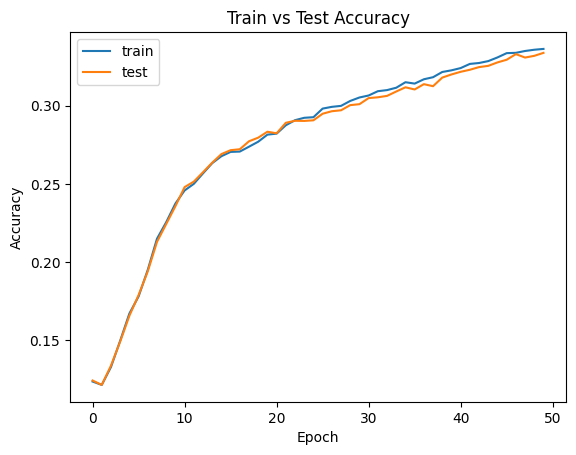

In [9]:
# 정확도 Plot
plot_acc(train_accs, test_accs)